In [1]:
from google.colab import drive
drive.mount('/content/drive/')

from drive.MyDrive.kursach import helpers
path = 'drive/MyDrive/kursach/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image

# Датасет

Для начала посмотрим на датасеты с _kaggle_, так как они дополнительно обработаны и ставят более узкую и простую задачу.

In [3]:
# Download dataset with Kaggle CLI (483 M).
# Reuired: installed Kaggle CLI and Kaggle API key.
# !kaggle competitions download -c covid-segmentation

# Load dataset from Google Drive
im_medseg, mk_medseg, im_radio, mk_radio = helpers.load_datasets(path, size=(128, 128))

Added drive/MyDrive/kursach/raw-data-kaggle/images_medseg.npy, shape (1, 100, 128, 128)
Added drive/MyDrive/kursach/raw-data-kaggle/masks_medseg.npy, shape (4, 100, 128, 128)
Added drive/MyDrive/kursach/raw-data-kaggle/images_radiopedia.npy, shape (1, 829, 128, 128)
Added drive/MyDrive/kursach/raw-data-kaggle/masks_radiopedia.npy, shape (4, 829, 128, 128)


## Medseg Images

In [4]:
im_medseg.shape  # -- 100 slices

(1, 100, 128, 128)

In [5]:
im_medseg[0, 0, :5, :5]  # --  одно значение -- интенсивность черно-белого

array([[-1408.51062012, -1408.51062012, -1408.51062012, -1408.51062012,
        -1408.51062012],
       [-1408.51062012, -1408.51062012, -1408.51062012, -1408.51062012,
        -1408.51062012],
       [-1408.51062012, -1408.51062012, -1408.51062012, -1408.51062012,
        -1408.51062012],
       [-1408.51062012, -1408.51062012, -1408.51062012, -1408.51062012,
        -1408.51062012],
       [-1408.51062012, -1408.51062012, -1408.51062012, -1408.51062012,
        -1408.51062012]])

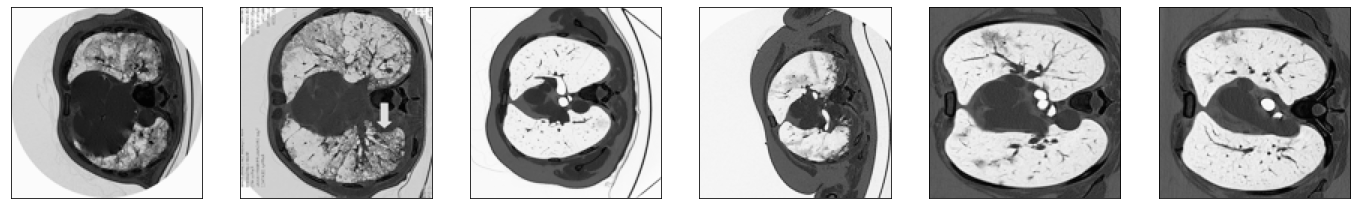

In [14]:
helpers.show_im_row(im_medseg[0, 0:6], size=4)

Видим, что снимки довольно разнородные: с разным фоном, разной яркостью и контрастом. Модели придется искать закономерности между различными областями картинки, а не определенными цветами.

## Medseg masks

In [7]:
mk_medseg[:, 0, 64, 64]  # if ith value is 1, a pixel has label i

array([0., 0., 0., 1.])

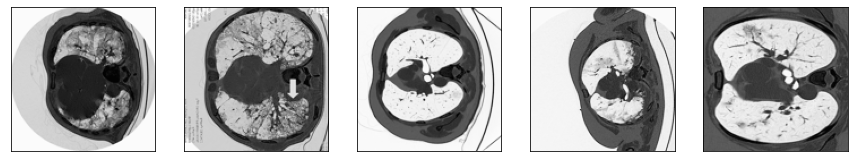

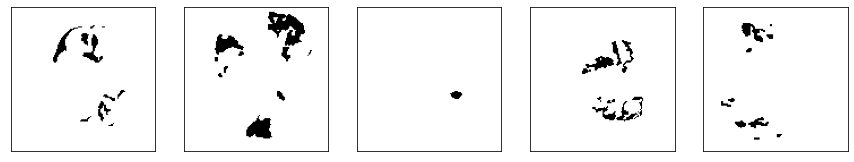

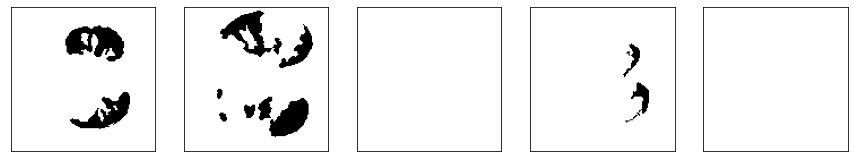

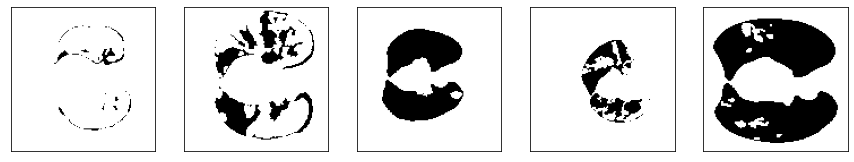

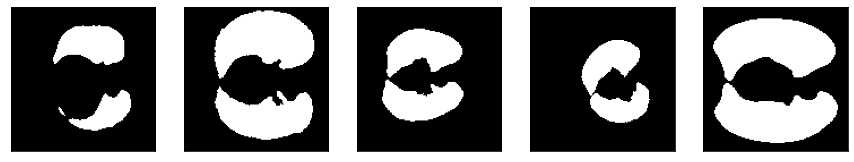

In [8]:
helpers.show_im_row(im_medseg[0, :5], size=3)
for i in range(4):
    helpers.show_im_row(mk_medseg[i, :5], size=3)

Имеем, что маски представляют собой массивы булов, которые для каждого пикселя определяют его соответствующую метку: 1 - матовое стекло, 2 - легочная консолидация, 3 - легкие (не 1 и 2), 4 - фон.

## Radiopedia

Можно предположить, что данные снимки будут выглядеть аналогично.

In [9]:
im_radio.shape

(1, 829, 128, 128)

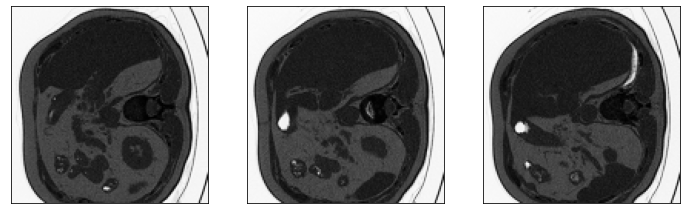

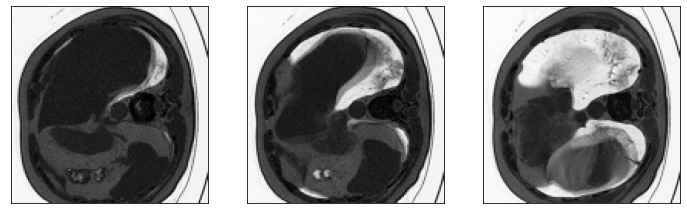

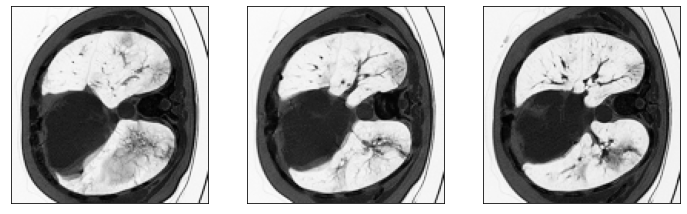

In [15]:
for i in range(0, 20, 9):
    helpers.show_im_row(im_radio[0, i:i+9:3], size=4)

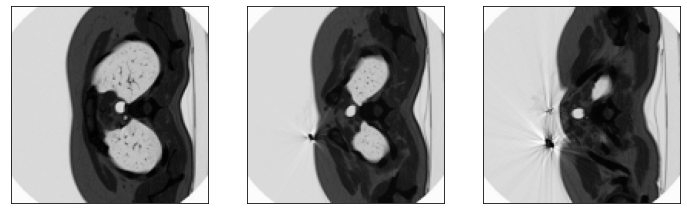

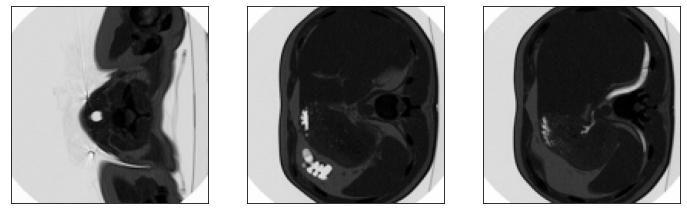

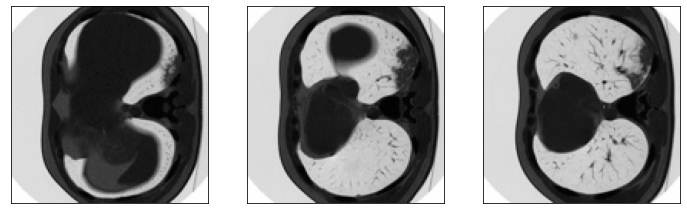

In [16]:
for i in range(780, 800, 9):
    helpers.show_im_row(im_radio[0, i:i+9:3], size=4)

Можем видеть, что тут присутствуют срезы одного и того же снимка. С ними нужно действовать аккуратно, чтобы не было переобучения. Возможно, стоит передавать информацию о том, что это срезы одних и тех же легких.

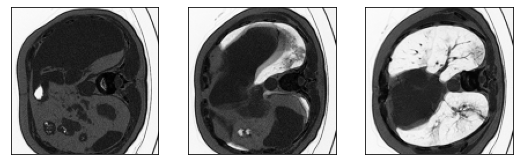

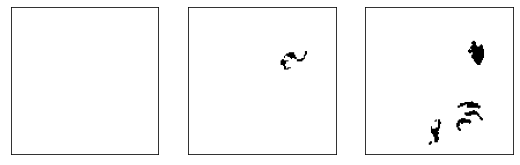

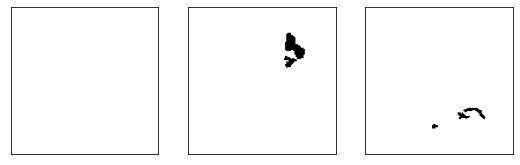

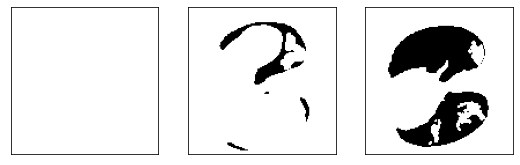

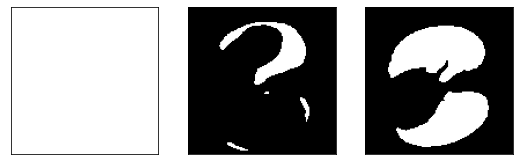

In [17]:
helpers.show_im_row(im_radio[0, 3:30:9], size=3)
for i in range(4):
    helpers.show_im_row(mk_radio[i, 3:30:9], size=3)

Видим, что некоторые срезы полностью белые. Вообще говоря, это небольшая неточность прорисовки, и на самом деле некоторые срезы полностью являются фоном:

In [18]:
mk_radio[3, 0]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

Что немного странно. Возможно, это ошибка в разметке данных, и стоит удалить подобные семплы.